# PHASE 4 - STEP 4.1: BASELINE CNN TRAINING

**Objective:** Train a simple CNN model as baseline for waste classification

**Expected Results:**
- Training time: ~30 minutes
- Validation accuracy: ~70-75%
- Establish baseline for comparison

---

## 1. IMPORTS & SETUP

In [10]:
# Suppress warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
)

# Print versions
print(f"TensorFlow version: {tf.__version__}")

# Check Keras version (Keras 3 doesn't have __version__)
try:
    print(f"Keras version: {keras.__version__}")
except AttributeError:
    print(f"Keras version: 3.x (integrated with TensorFlow {tf.__version__})")

# Check GPU/Metal availability
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0}")
if len(gpus) > 0:
    print(f"GPU devices: {gpus}")
  print(f" Running on Apple Silicon with Metal acceleration")
else:
    print(f"Running on CPU only")

# Set plot style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
    print(" Seaborn style not available, using default")

sns.set_palette("husl")

print("\n All imports successful!")


TensorFlow version: 2.15.0
Keras version: 3.x (integrated with TensorFlow 2.15.0)
GPU available: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
 Running on Apple Silicon with Metal acceleration

 All imports successful!


## 2. CONFIGURATION

In [11]:
# 2. CONFIGURATION

# Paths (notebook is in notebooks/, need to go up one level)
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')
OUTPUT_DIR = Path('../outputs')

# Create directories if they don't exist
MODEL_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Training parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001

print("="*70)
print("CONFIGURATION")
print("="*70)
print(f"Image size: {IMG_SIZE}×{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Max epochs: {EPOCHS}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"\nData directory: {DATA_DIR.absolute()}")
print(f"Model directory: {MODEL_DIR.absolute()}")
print(f"Output directory: {OUTPUT_DIR.absolute()}")

# Verify directories exist
print(f"\nDirectory check:")
print(f" Data exists: {DATA_DIR.exists()} {'' if DATA_DIR.exists() else ''}")
print(f" Models exists: {MODEL_DIR.exists()} {'' if MODEL_DIR.exists() else ''}")
print(f" Outputs exists: {OUTPUT_DIR.exists()} {'' if OUTPUT_DIR.exists() else ''}")
print("="*70)

CONFIGURATION
Image size: 224×224
Batch size: 32
Max epochs: 30
Learning rate: 0.001

Data directory: /Users/caoduong22102004gmail.com/waste-classification-vn/notebooks/../data/processed
Model directory: /Users/caoduong22102004gmail.com/waste-classification-vn/notebooks/../models
Output directory: /Users/caoduong22102004gmail.com/waste-classification-vn/notebooks/../outputs

Directory check:
 Data exists: True 
 Models exists: True 
 Outputs exists: True 


## 3. LOAD CLASS WEIGHTS

In [12]:
# Load class weights from Step 3.2
print("Loading class weights...\n")

weights_path = DATA_DIR / 'class_weights_simple.json'
with open(weights_path, 'r') as f:
    weights_data = json.load(f)

# Convert string keys to integers
class_weights = {int(k): v for k, v in weights_data['recommended_weights'].items()}
class_to_idx = weights_data['class_to_idx']
num_classes = len(class_weights)

print(f"Number of classes: {num_classes}")
print(f"\nClass weights:")
for idx, weight in sorted(class_weights.items()):
    class_name = [k for k, v in class_to_idx.items() if v == idx][0]
    print(f"  {idx}: {class_name:<15s} → {weight:.4f}")

print("\n Class weights loaded!")

Loading class weights...

Number of classes: 9

Class weights:
  0: battery         → 1.8245
  1: biological      → 1.7504
  2: cardboard       → 1.9358
  3: glass           → 0.8578
  4: metal           → 2.2416
  5: paper           → 1.6408
  6: plastic         → 1.9934
  7: textile         → 0.2360
  8: trash           → 2.4764

 Class weights loaded!


## 4. CREATE DATA GENERATORS

In [13]:
print("Creating data generators...\n")

# Training generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    directory=str(DATA_DIR / 'train'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    directory=str(DATA_DIR / 'val'),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

print(f" Training samples: {train_generator.samples:,}")
print(f" Validation samples: {val_generator.samples:,}")
print(f" Steps per epoch: {len(train_generator)}")
print(f" Validation steps: {len(val_generator)}")

# Verify class mapping
print(f"\nClass indices: {train_generator.class_indices}")

Creating data generators...

Found 10854 images belonging to 9 classes.
Found 2328 images belonging to 9 classes.
 Training samples: 10,854
 Validation samples: 2,328
 Steps per epoch: 340
 Validation steps: 73

Class indices: {'battery': 0, 'biological': 1, 'cardboard': 2, 'glass': 3, 'metal': 4, 'paper': 5, 'plastic': 6, 'textile': 7, 'trash': 8}


## 5. BUILD BASELINE CNN MODEL

In [14]:
def create_baseline_cnn(input_shape=(224, 224, 3), num_classes=9):
    """Create baseline CNN model"""
    
    model = models.Sequential([
        # Input
        layers.Input(shape=input_shape),
        
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
    # ADD THIS: Global Average Pooling (reduces from 28×28×128 to 128)
        layers.GlobalAveragePooling2D(),  # ← KEY CHANGE!
        
        # Dense layers (much smaller now!)
        layers.Dense(256, activation='relu',
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(0.0001)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Output
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create model
print("Creating Baseline CNN model...\n")
model = create_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes)

# Display summary
model.summary()

# Count parameters
trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
non_trainable_params = sum([tf.size(w).numpy() for w in model.non_trainable_weights])
total_params = trainable_params + non_trainable_params

print(f"\n{'='*70}")
print("MODEL STATISTICS")
print(f"{'='*70}")
print(f"Total parameters:       {total_params:,}")
print(f"Trainable parameters:   {trainable_params:,}")
print(f"Non-trainable params:   {non_trainable_params:,}")
print(f"Model size:             {total_params * 4 / (1024*1024):.2f} MB")
print(f"{'='*70}")


Creating Baseline CNN model...

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 224, 224, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 224, 224, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                        

## 6. COMPILE MODEL

In [15]:
print("Compiling model...\n")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(" Model compiled!")
print(f"   Optimizer: Adam (lr={LEARNING_RATE})")
print(f"   Loss: Categorical Crossentropy")
print(f"   Metrics: Accuracy")

Compiling model...

 Model compiled!
   Optimizer: Adam (lr=0.001)
   Loss: Categorical Crossentropy
   Metrics: Accuracy


## 7. SETUP CALLBACKS

In [16]:
print("Setting up callbacks...\n")

# Model checkpoint
checkpoint = ModelCheckpoint(
    filepath=str(MODEL_DIR / 'baseline_cnn_best.h5'),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# CSV logger
csv_logger = CSVLogger(
    filename=str(OUTPUT_DIR / 'baseline_training_log.csv'),
    append=False
)

callbacks = [checkpoint, early_stop, reduce_lr, csv_logger]

print(" Callbacks configured:")
print("   - ModelCheckpoint (save best model)")
print("   - EarlyStopping (patience=10)")
print("   - ReduceLROnPlateau (patience=5)")
print("   - CSVLogger")

Setting up callbacks...

 Callbacks configured:
   - ModelCheckpoint (save best model)
   - EarlyStopping (patience=10)
   - ReduceLROnPlateau (patience=5)
   - CSVLogger


## 8. TRAIN MODEL

**This will take ~30 minutes on Mac M4**

Watch for:
- Accuracy increasing
- Loss decreasing
- Early stopping if no improvement

In [17]:
print("="*70)
print("STARTING TRAINING")
print("="*70)
print(f"\nTraining for up to {EPOCHS} epochs...")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(val_generator)}")
print(f"\nStart time: {datetime.now().strftime('%H:%M:%S')}")
print("\n")

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"End time: {datetime.now().strftime('%H:%M:%S')}")

STARTING TRAINING

Training for up to 30 epochs...
Steps per epoch: 340
Validation steps: 73

Start time: 16:30:10


Epoch 1/30


2025-12-26 16:30:12.277737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-12-26 16:30:12.362757: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


340/340 [==============================] - ETA: 0s - loss: 2.1515 - accuracy: 0.3033
Epoch 1: val_accuracy improved from -inf to 0.37242, saving model to ../models/baseline_cnn_best.h5
340/340 [==============================] - 102s 287ms/step - loss: 2.1515 - accuracy: 0.3033 - val_loss: 1.8930 - val_accuracy: 0.3724 - lr: 0.0010
Epoch 2/30


/Users/caoduong22102004gmail.com/waste-classification-vn/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


340/340 [==============================] - ETA: 0s - loss: 1.8080 - accuracy: 0.3856
Epoch 2: val_accuracy did not improve from 0.37242
340/340 [==============================] - 111s 327ms/step - loss: 1.8080 - accuracy: 0.3856 - val_loss: 7.7894 - val_accuracy: 0.0657 - lr: 0.0010
Epoch 3/30
340/340 [==============================] - ETA: 0s - loss: 1.6903 - accuracy: 0.3943
Epoch 3: val_accuracy did not improve from 0.37242
340/340 [==============================] - 122s 358ms/step - loss: 1.6903 - accuracy: 0.3943 - val_loss: 2.0330 - val_accuracy: 0.3346 - lr: 0.0010
Epoch 4/30
340/340 [==============================] - ETA: 0s - loss: 1.6562 - accuracy: 0.4168
Epoch 4: val_accuracy did not improve from 0.37242
340/340 [==============================] - 119s 350ms/step - loss: 1.6562 - accuracy: 0.4168 - val_loss: 2.6637 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 5/30
340/340 [==============================] - ETA: 0s - loss: 1.6164 - accuracy: 0.4343
Epoch 5: val_accuracy did not 

## 9. VISUALIZE TRAINING HISTORY

 Plot saved to: ../outputs/baseline_training_history.png


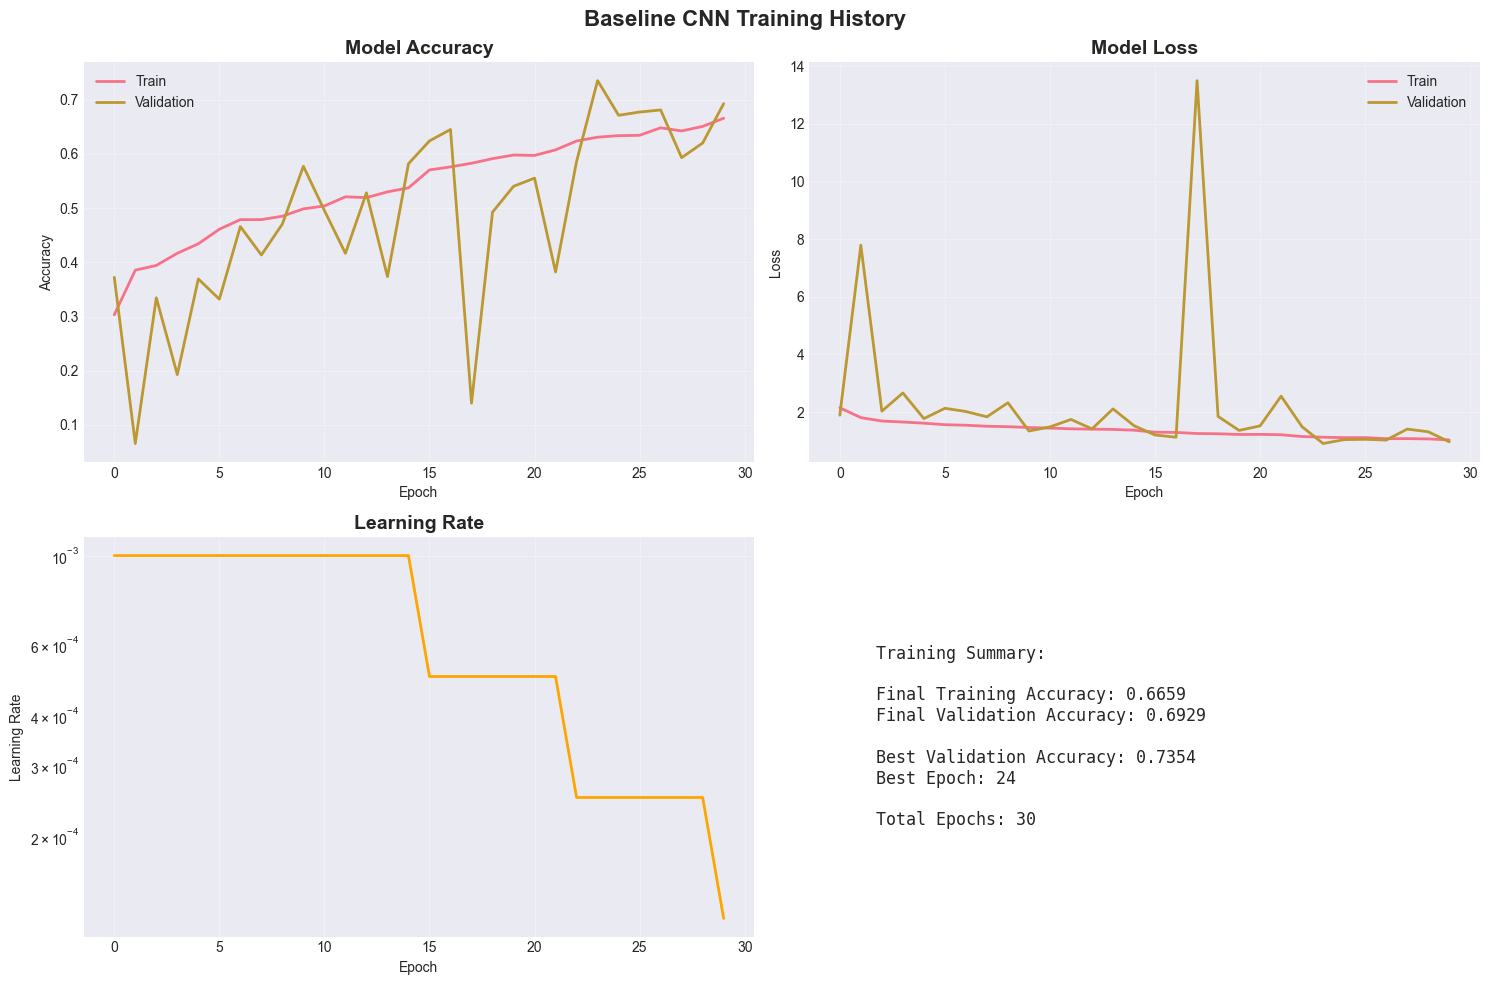

In [18]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='orange')
    axes[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'Learning rate not tracked', 
                   ha='center', va='center', fontsize=12)
    axes[1, 0].axis('off')

# Summary
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1

summary_text = f"""
Training Summary:

Final Training Accuracy: {final_train_acc:.4f}
Final Validation Accuracy: {final_val_acc:.4f}

Best Validation Accuracy: {best_val_acc:.4f}
Best Epoch: {best_epoch}

Total Epochs: {len(history.history['accuracy'])}
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
               verticalalignment='center', family='monospace')
axes[1, 1].axis('off')

plt.suptitle('Baseline CNN Training History', fontsize=16, fontweight='bold')
plt.tight_layout()

# Save
save_path = OUTPUT_DIR / 'baseline_training_history.png'
plt.savefig(save_path, dpi=150, bbox_inches='tight')
print(f" Plot saved to: {save_path}")

plt.show()

## 📈 10. EVALUATE MODEL

In [19]:
print("Evaluating model on validation set...\n")

# Evaluate
results = model.evaluate(val_generator, verbose=1)

print("\n" + "="*70)
print("VALIDATION RESULTS")
print("="*70)
print(f"Loss:     {results[0]:.4f}")
print(f"Accuracy: {results[1]:.4f} ({results[1]*100:.2f}%)")
print("="*70)

Evaluating model on validation set...

73/73 [==============================] - 4s 61ms/step - loss: 0.9697 - accuracy: 0.6929

VALIDATION RESULTS
Loss:     0.9697
Accuracy: 0.6929 (69.29%)


## 💾 11. SAVE RESULTS

In [20]:
# Prepare results
training_results = {
    'model': 'baseline_cnn',
    'timestamp': datetime.now().isoformat(),
    'configuration': {
        'image_size': IMG_SIZE,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'loss': 'categorical_crossentropy'
    },
    'training_history': {
        'epochs_completed': len(history.history['accuracy']),
        'final_train_accuracy': float(history.history['accuracy'][-1]),
        'final_val_accuracy': float(history.history['val_accuracy'][-1]),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'best_epoch': int(history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
    },
    'evaluation_metrics': {
        'loss': float(results[0]),
        'accuracy': float(results[1])
    },
    'class_weights_used': class_weights
}

# Save to JSON
output_path = OUTPUT_DIR / 'baseline_training_results.json'
with open(output_path, 'w') as f:
    json.dump(training_results, f, indent=2)

print(f" Results saved to: {output_path}")

 Results saved to: ../outputs/baseline_training_results.json


## 12. FINAL SUMMARY

In [21]:
print("\n" + "="*70)
print(" BASELINE CNN TRAINING COMPLETE!")
print("="*70)

print("\n📁 Outputs:")
print(f"   Model: {MODEL_DIR / 'baseline_cnn_best.h5'}")
print(f"   History: {OUTPUT_DIR / 'baseline_training_history.png'}")
print(f"   Log: {OUTPUT_DIR / 'baseline_training_log.csv'}")
print(f"   Results: {OUTPUT_DIR / 'baseline_training_results.json'}")

print("\n Final Performance:")
print(f"   Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"   Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"   Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")

print("\n" + "="*70)


 BASELINE CNN TRAINING COMPLETE!

📁 Outputs:
   Model: ../models/baseline_cnn_best.h5
   History: ../outputs/baseline_training_history.png
   Log: ../outputs/baseline_training_log.csv
   Results: ../outputs/baseline_training_results.json

 Final Performance:
   Training Accuracy: 0.6659
   Validation Accuracy: 0.6929
   Best Validation Accuracy: 0.7354

